# Data
Load and preprocess **Pavia University**

In [0]:
!pip install attributedict
import numpy as np
from sklearn.decomposition import PCA
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import os
import random
from random import shuffle
from skimage.transform import rotate
import scipy.ndimage
from sklearn.model_selection import train_test_split
import scipy

from google.colab import drive
drive.mount('/content/gdrive')

!pip install GoogleDriveDownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip


def load_pavia():
  
  gdd.download_file_from_google_drive(file_id='146WN2eZ6Syf-z1KMVRw9GmZdBu_g1JBj',
                                    dest_path='./datasets/paviau.mat', unzip=False)

  gdd.download_file_from_google_drive(file_id='1L9OoAHnLVmPGbfKx8NhEbugxMzE1PG4j',
                                    dest_path='./datasets/paviau_gt.mat', unzip=False)

  X = sio.loadmat('./datasets/paviau.mat')['paviaU']
  y = sio.loadmat('./datasets/paviau_gt.mat')['paviaU_gt']

  return X, y

  
  
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
  margin = int((windowSize - 1) / 2)
  zeroPaddedX = padWithZeros(X, margin=margin)
  # split patches
  patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
  patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
  patchIndex = 0
  for r in range(margin, zeroPaddedX.shape[0] - margin):
      for c in range(margin, zeroPaddedX.shape[1] - margin):
          patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
          patchesData[patchIndex, :, :, :] = patch
          patchesLabels[patchIndex] = y[r-margin, c-margin]
          patchIndex = patchIndex + 1
  if removeZeroLabels:
      patchesData = patchesData[patchesLabels>0,:,:,:]
      patchesLabels = patchesLabels[patchesLabels>0]
      patchesLabels -= 1
  return patchesData, patchesLabels
  
  
def padWithZeros(X, margin=2):
  newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
  x_offset = margin
  y_offset = margin
  newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
  return newX
  
def standartizeData(X):
  newX = np.reshape(X, (-1, X.shape[2]))
  scaler = preprocessing.StandardScaler().fit(newX)  
  newX = scaler.transform(newX)
  newX = np.reshape(newX, (X.shape[0],X.shape[1],X.shape[2]))
  return newX, scaler
  
  
def applyPCA(X, numComponents=75):
  newX = np.reshape(X, (-1, X.shape[2]))
  pca = PCA(n_components=numComponents, whiten=True)
  newX = pca.fit_transform(newX)
  newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
  return newX, pca
  
  
def diff(first, second):
  second = set(second)
  return [item for item in first if item not in second]


def splitTrainTestSet(X, y, testRatio=0.10):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=345,
                                                      stratify=y)
  return X_train, X_test, y_train, y_test
  
  
def AugmentData(X_train):
  for i in range(int(X_train.shape[0]/2)):
      patch = X_train[i,:,:,:]
      num = random.randint(0,2)
      if (num == 0):
          flipped_patch = np.flipud(patch)
      if (num == 1):
          flipped_patch = np.fliplr(patch)
      if (num == 2):
          no = random.randrange(-180,180,30)
          flipped_patch = scipy.ndimage.interpolation.rotate(patch, no,axes=(1, 0),
                                                             reshape=False, output=None, order=3, mode='constant', cval=0.0, prefilter=False)

      patch2 = flipped_patch
      X_train[i,:,:,:] = patch2

  return X_train
  
  
def oversampleWeakClasses(X, y):
  uniqueLabels, labelCounts = np.unique(y, return_counts=True)
  maxCount = np.max(labelCounts)
  labelInverseRatios = maxCount / labelCounts  
  # repeat for every label and concat
  newX = X[y == uniqueLabels[0], :, :, :].repeat(round(labelInverseRatios[0]), axis=0)
  newY = y[y == uniqueLabels[0]].repeat(round(labelInverseRatios[0]), axis=0)
  for label, labelInverseRatio in zip(uniqueLabels[1:], labelInverseRatios[1:]):
      cX = X[y== label,:,:,:].repeat(round(labelInverseRatio), axis=0)
      cY = y[y == label].repeat(round(labelInverseRatio), axis=0)
      newX = np.concatenate((newX, cX))
      newY = np.concatenate((newY, cY))
  np.random.seed(seed=42)
  rand_perm = np.random.permutation(newY.shape[0])
  newX = newX[rand_perm, :, :, :]
  newY = newY[rand_perm]
  return newX, newY
  
  
  
def savePreprocessedData(X_trainPatches, X_testPatches, y_trainPatches, y_testPatches, name):
  
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  with open("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/XtrainWindowSize" + name + ".npy", 'wb') as outfile:
      np.save(outfile, X_trainPatches)
  with open("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/XtestWindowSize" + name + ".npy", 'wb') as outfile:
      np.save(outfile, X_testPatches)
  with open("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/ytrainWindowSize" + name + ".npy", 'wb') as outfile:
      np.save(outfile, y_trainPatches)
  with open("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/ytestWindowSize" + name + ".npy", 'wb') as outfile:
      np.save(outfile, y_testPatches)
      
#Change the locations according to the above folders    
def get_pavia(numComponents=30,windowSize=5,testRatio=0.25,saved=False):
  name = 'pavia' #Used to load the data

  if saved == False:
    X, y = load_pavia()
    X,_ = standartizeData(X)
    if numComponents != -1:
      X,pca = applyPCA(X,numComponents=numComponents)
    XPatches, yPatches = createPatches(X, y, windowSize=windowSize)
    X_train, X_test, y_train, y_test = splitTrainTestSet(XPatches, yPatches, testRatio)
    X_train, y_train = oversampleWeakClasses(X_train, y_train)
    X_train = AugmentData(X_train)
    savePreprocessedData(X_train, X_test, y_train, y_test, name=name)

  else:
    X_train = np.load("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/XtrainWindowSize" + name + ".npy")
    y_train = np.load("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/ytrainWindowSize" + name + ".npy")
    X_test = np.load("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/XtestWindowSize" + name + ".npy")
    y_test = np.load("/content/gdrive/My Drive/colab/Ladder-CNN/preprocessedData/ytestWindowSize" + name + ".npy")
    
  return X_train, y_train, X_test, y_test

  

# Conv. Ladder Net
**Architecture**: conv90-conv30-conv15-fc30-soft

**Params**:  Filter sizes, fully connected arch., kernel sizes, denoising costs, number of epochs, number of labeled points, noise standard deviation, learning rate, decay after for lr reduction



In [0]:
import tensorflow as tf
from attributedict.collections import AttributeDict

def train(X,y,X_test=None,y_test=None,N=3,filter_size=[90,30,15],fc=[],kernel_size=5,
          denoising_cost=[10,1,0.1,0.1,0.1],num_epochs=150,batch_size=200,num_labeled=100,noise_std=0.3,lr=0.02,
          decay_after=15):
  
  assert len(denoising_cost) is 2+len(filter_size)+len(fc), "Please specify denoising cost for every Layer. len(denoising_cost) != 2+len(fc)+len(filter_size)"
  
  tf.reset_default_graph()
  tf.set_random_seed(1234)
  #We double the batch size here. This has the advantage that in case num_labeled is -1 (use all labels) we can use half of the
  #batch size for the clean encoder and the other half for the unsupervised run
  batch_size *= 2
 
  #Number of convolutions
  N = len(filter_size)
  #Number of fully connected layers
  K = len(fc)
  
  #Shape of X: (?,WND_SZE,WND_SZE, N_CHANNELS)
  WND_SZE = X.shape[1]
  N_CHANNELS = X.shape[3]
  N_CLASSES = len(np.unique(y))
  N_EXAMPLES = X.shape[0]
  DEPTH = X.shape[-1]
  
  L = K+N+2 #Input+Convs+Softmax
  
  #Create list of action,output-shape pairs, e.g. fs=[90,30,15] & fc=[100,50,20] would correspond to
  #{'conv',(?,5,5,90);'conv',(?,5,5,30);'conv',(?,5,5,15);'relu',(?,100);'relu',(?,50);'relu',(?,20)}
  #Implicit: 'flatten' & 'softmax'
  shapes = [('conv',s) for s in filter_size]+[('relu',s) for s in fc]+[('softmax',N_CLASSES)]
  
  num_labeled_tf = tf.placeholder(tf.int32, shape=())
  
  n_classes = len(np.unique(y_test))
  n_labeled_per_class = int(num_labeled/n_classes)

  #Create X_labeled and X_unlabeled where X_labeled has num_labeled entries which are balanced w.r.t. the class labels
  indices = np.arange(len(y))
  i_labeled = []
  for c in range(n_classes):
        i = indices[y==c][:n_labeled_per_class]
        i_labeled += list(i)


  X_labeled = X[i_labeled,:,:,:]
  y_labeled = y[i_labeled]


  if num_labeled > batch_size:
    n_labeled_per_class = int(0.5*batch_size/n_classes) #Use 100 points for the unlabeled and the rest for the labeled
  else:
    n_labeled_per_class = int(num_labeled/n_classes)

  #Take everything as unlabeled data
  X_unlabeled = X

  #Create dataset from tensor slices
  features_placeholder_labeled = tf.placeholder(X_labeled.dtype, X_labeled.shape)
  features_placeholder = tf.placeholder(X_unlabeled.dtype, X_unlabeled.shape)
  labels_placeholder = tf.placeholder(y.dtype, y.shape) #This is for num_labeled == -1
  labels_placeholder_labeled = tf.placeholder(y_labeled.dtype, y_labeled.shape)

  ds_lab = tf.data.Dataset.from_tensor_slices((features_placeholder_labeled, labels_placeholder_labeled))

  ds_unlab = tf.data.Dataset.from_tensor_slices(features_placeholder)
  ds_unlab = ds_unlab.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=batch_size-n_labeled_per_class*n_classes, drop_remainder=True).repeat()
  print("Size unlab batch: %s" % (batch_size-n_labeled_per_class*n_classes))

  ds_full = tf.data.Dataset.from_tensor_slices((features_placeholder,labels_placeholder))
  ds_full = ds_full.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=batch_size, drop_remainder=True).repeat()

  iterator_full = ds_full.make_initializable_iterator()
  iterator_unlab = ds_unlab.make_initializable_iterator()
  #Create datasets for each class
  datasets = [ds_lab.filter(lambda x,y : tf.equal(y,lab)) for lab in range(n_classes)]
  iterators = []
  nexts = []

  next = ()

  if num_labeled != -1:
    for idx,d in enumerate(datasets):
      datasets[idx] = d.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=n_labeled_per_class, drop_remainder=True).repeat()
      iterators =iterators + [datasets[idx].make_initializable_iterator()]
      nexts = nexts + [iterators[idx].get_next()]

    seed = np.random.randint(100)
    X_out = tf.random.shuffle(tf.concat([x[0] for x in nexts],axis=0),seed = seed)
    y_out = tf.random.shuffle(tf.concat([x[1] for x in nexts],axis=0),seed = seed)
    y_out_again = tf.random.shuffle(tf.concat([x[1] for x in nexts],axis=0),seed = seed)

    X_out_un = iterator_unlab.get_next()
    y_out_un = tf.constant(shape=([batch_size-n_labeled_per_class*n_classes]), value = -1,dtype=tf.float64)

    next = (tf.concat([X_out,X_out_un],axis=0), tf.concat([y_out,y_out_un],axis=0))
  else:
    next = iterator_full.get_next()

  
  if num_labeled == -1 or num_labeled > batch_size:
    num_labeled = batch_size/2 #Since we doubled the batch size before.
    
  
  features_placeholder_test = tf.placeholder(X_test.dtype, shape=(None,WND_SZE,WND_SZE,N_CHANNELS),name='X_test')
  labels_placeholder_test = tf.placeholder(y_test.dtype, shape=(None,),name='y_test')
  
  
  inputs =  tf.placeholder(tf.float32, shape=(None,WND_SZE,WND_SZE,N_CHANNELS),name='inputs')
  outputs = tf.placeholder(tf.float32, shape=(None,),name='outputs')
  isTrain = tf.placeholder(tf.bool, shape=())
  
  
  #Gamma and beta initialization: Need one gamma (for softmax) and N+K many with different shapes. 
  gamma = tf.Variable(tf.ones([N_CLASSES])) #Take the prev. to last one e.g. 90
  beta = [tf.Variable(tf.zeros([kernel_size,kernel_size,fs])) for fs in filter_size]+[tf.Variable(tf.zeros([s])) for s in fc]
  beta = beta + [tf.Variable(tf.zeros([N_CLASSES]))] #For the last layer
  
  def usetrain():
    inputs = next[0]
    outputs = next[1]
    return inputs, outputs
  def usetest():
    return features_placeholder_test, labels_placeholder_test

  assert X_test is not None, "Check if Test data is present in session"
  input, output = tf.cond(isTrain, usetrain, usetest)
  
  #Helper functions
  join = lambda l, u: tf.concat([l, u], axis=0) #Stack in the depth (batch, height, w, depth)
  labeled = lambda x: x[:num_labeled_tf] if x is not None else x #Use tf.getitem (implicitly)
  unlabeled = lambda x: x[num_labeled_tf:] if x is not None else x
  split_lu = lambda x: (labeled(x), unlabeled(x))
  
  #Running average for the clean pass and the labeled points
  ema = tf.train.ExponentialMovingAverage(decay=0.9999)  # to calculate the moving averages of mean and variance
  bn_assigns = []
  #Initialize with shapes (1,kernel_size, kernel_size, filter_size)
  running_mean = [tf.Variable(tf.constant(0.0, shape=[1,kernel_size,kernel_size,f]), trainable=False) for f in filter_size]+[tf.Variable(tf.constant(0.0, shape=[s]), trainable=False) for s in fc]
  running_mean = running_mean + [tf.Variable(tf.constant(0.0, shape=[N_CLASSES]))]
  running_var = [tf.Variable(tf.constant(1.0, shape=[1,kernel_size,kernel_size,f]), trainable=False) for f in filter_size]+[tf.Variable(tf.constant(1.0, shape=[s]), trainable=False) for s in fc]
  running_var = running_var + [tf.Variable(tf.constant(1.0, shape=[N_CLASSES]))]
  
  
  def new_activation_dict():
    return AttributeDict({'z': {}, 'h': {}, 's': {}, 'm': {}})
  
  if shapes[-2][0] == 'conv':
    W = tf.Variable(tf.random_normal(shape=[kernel_size**2 * filter_size[-1],N_CLASSES])) #In case the last layer is a conv layer
    V = tf.Variable(tf.random_normal(shape=[N_CLASSES, kernel_size**2 * filter_size[-1]])) #Matrix for decoder. Takes the softmax layer shape (?,9) -> (?,kernel_size**2 * filter_size[-1]) to then reshape to a tensor  
  else:
    W = tf.Variable(tf.random_normal(shape=[shapes[-2][1],N_CLASSES])) #In case the last layer is a fully connected layer.
    V = tf.Variable(tf.random_normal(shape=[N_CLASSES,shapes[-2][1]])) #Matrix for decoder. Takes the softmax layer shape (?,9) -> (?,kernel_size**2 * filter_size[-1]) / (?,fully_connected_shape) -> reshape or not
  
  if K>0:
    W_fc = [tf.Variable(tf.random_normal(shape=[kernel_size**2 * filter_size[-1],fc[0]]))] #The first weight matrix for the fc part.
    V_fc = [tf.Variable(tf.random_normal(shape=[fc[0],kernel_size**2 * filter_size[-1]]))] #Input dimesnion is fc[0], e.g. fc=[10,20,30], encoder: (?,5,5,30)->(?,10)->(?,20)->(?,30)->(?,9)->(Decoder)(?,30)->(?,20)->(?,10)->(?,5,5,30)
    if K>1: #TODO: Works without if? 
      W_fc = W_fc + [tf.Variable(tf.random_normal(shape=[fc[i-1],fc[i]])) for i in range(1,K)]
      V_fc = V_fc + [tf.Variable(tf.random_normal(shape=[fc[i],fc[i-1]])) for i in range(1,K)] #The matrix that 

  
  def g(z_lat, u, size):
    shape = tf.shape(u)[1:] #Don't take the batch size as a dimension 
    wi = lambda inits, name: tf.Variable(inits * tf.ones(size), name=name)
    a1 = wi(0., 'a1')
    a2 = wi(1., 'a2')
    a3 = wi(0., 'a3')
    a4 = wi(0., 'a4')
    a5 = wi(0., 'a5')
    a6 = wi(0., 'a6')
    a7 = wi(1., 'a7')
    a8 = wi(0., 'a8')
    a9 = wi(0., 'a9')
    a10 = wi(0., 'a10')
    mu = a1 * tf.sigmoid(a2 * u + a3) + a4 * u + a5
    v = a6 * tf.sigmoid(a7 * u + a8) + a9 * u + a10
    z_est = (z_lat - mu) * v + mu
    return z_est
  
  
  #Encoder
  def encoder(input, noise_std):
    with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
      #Apply noise to the input
      h = tf.cast(input,tf.float32) + tf.random_normal(dtype=tf.float32,shape=tf.shape(input)) * noise_std #Normal noise 0 mean 1 std
      d = AttributeDict() #This is what we will return. It will contain all the information we need
      d.unlabeled = new_activation_dict()
      d.labeled = new_activation_dict()
      d.unlabeled.z[0] = unlabeled(h)
      d.labeled.z[0] = labeled(h)

      for i in range(1,L): #Go through the convolutional layers, if we are at i==N+1, we need to flatten and apply W
        d.labeled.h[i-1], d.unlabeled.h[i-1] = split_lu(h)
        
        operation = shapes[i-1][0]
        output_shape = shapes[i-1][1]

        if operation=='softmax':
          z = tf.layers.flatten(h)
          z = tf.matmul(z,W)
          keep_dims = False
        elif operation=='conv':
          #Compute new z by applying convolution followed by ReLU after normalization
          z = tf.layers.conv2d(h,filters=filter_size[i-1], kernel_size=kernel_size, padding='same')
          keep_dims = True
        else:
          #No need to check for input dim, because flatten preserves batch axis
          z = tf.layers.flatten(h)
          z = tf.matmul(z,W_fc[i-1-N])
          keep_dims = False
          
        #Shape: (?,5,5,filter_size) or (?,fc_size)
        #Normalize
        z_lbld, z_unlbld = split_lu(z)

        m_unlbld, s_unlbld = tf.nn.moments(z_unlbld, axes=[0], keep_dims=keep_dims) #Compute along depth
        m_lbld, s_lbld = tf.nn.moments(z_lbld, axes=[0], keep_dims=keep_dims)
        #Shape: (1,5,5,filter_size)

        if noise_std == 0: #Clean pass
          #Update the running averages and get the mean and variance of the labeled points again
          assign_mean = running_mean[i-1].assign(m_lbld)
          assign_var = running_var[i-1].assign(s_lbld)
          with tf.control_dependencies([assign_mean, assign_var]):
            bn_assigns.append(ema.apply([running_mean[i-1], running_var[i-1]]))
            m_lbld = ema.average(running_mean[i-1])
            s_lbld = ema.average(running_var[i-1])


        z = join(
          (z_lbld-m_lbld) / tf.sqrt(s_lbld + 1e-10),
          (z_unlbld-m_unlbld) / tf.sqrt(s_unlbld + 1e-10))

        if noise_std > 0:
          z += tf.random_normal(tf.shape(z)) * noise_std

        z_lateral = z

        if i==L-1: #We need to apply softmax and multiply with gamma
          z = tf.add(z,beta[i-1])
          z = tf.multiply(z, gamma)
          h = tf.nn.softmax(z)
        else:  
          #Now apply activation. But before we apply the activation, add beta and multiply
          #with gamma. Gamma is not used for ReLU. We apply Gamma for the softmax layer.
          z += beta[i-1] #i starts at 1, but beta starts at 0
          #Apply ReLU
          h = tf.nn.relu(z) #h gets assigned at the beginning of the for loop

        #Now save the variables: z_lateral, m_unlbld, s_unlbld, h
        d.labeled.z[i], d.unlabeled.z[i] = split_lu(z_lateral) #The real z has been compromised
        d.unlabeled.s[i] = s_unlbld
        d.unlabeled.m[i] = m_unlbld

      #Get the last h.
      d.labeled.h[i], d.unlabeled.h[i] = split_lu(h)

      return h, d
   #End encoder
  
  
  #If isTrain is false, use the encoder without the splitting
  y_clean, clean = encoder(input, noise_std=0.0)
  
  #Get the clean run
  #y_clean, clean = encoder(input, noise_std=0.0, isTrain=True)
  #Get the corrupted encoder run
  y_corrupted, corr = encoder(input, noise_std=noise_std)
  
  #Use this to store the z_est etc.
  est = new_activation_dict()
  
  #Decoder path
  filter_dims = [DEPTH] + filter_size
  #Start at index N+1 and go through index 0, N=3
  cost_recon = []
  for i in np.arange(L)[::-1]: #Start from L-1 --> 0, L+1 = N+2 = 6, 30-90-30-15-9
    #Get all the information we need
    z_corr = corr.unlabeled.z[i]
    z_clean = clean.unlabeled.z[i]
    if i != 0:
      z_clean_s = clean.unlabeled.s[i]
      z_clean_m = clean.unlabeled.m[i]
      
    if i==L-1: #The top level
      #Just normalize the (?,9) output
      ver = corr.unlabeled.h[i]
      size = [N_CLASSES]
      keep_dims = False
    elif i==L-2: #Apply the matrix V
      ver = tf.matmul(est.z.get(i+1), V) #This produces a (?,375)
      if K==0: #If we do not have any fully connected layers after this, then reshape
        ver = tf.reshape(ver, shape=[-1,WND_SZE,WND_SZE,filter_size[-1]])
        size = [WND_SZE, WND_SZE, filter_size[-1]]
        keep_dims = True
      else:
        size = [fc[-1]]
        keep_dims = False
    else:
      #Get the corresponding operation:
      operation = shapes[i][0]
      print(operation)
      if operation == 'conv':
        #Deconvolve. This is just a convolution to a new filter size. We leave the kernel size untouched.
        ver = tf.layers.conv2d(est.z.get(i+1),filters=filter_dims[i], kernel_size=kernel_size, padding='same')
        size = [WND_SZE, WND_SZE, filter_dims[i]]
        keep_dims = True
      else: #Operation must be to apply the V_fc matrix
        tmp = tf.layers.flatten(est.z.get(i+1)) #Flatten. Note: This can bet optimized by checking if we really need to reshape
        ver = tf.matmul(tmp,V_fc[i-N])
        if (i-N) == 0: #This was the last fully connected layer, now reshape
          ver = tf.reshape(ver, shape=[-1,WND_SZE,WND_SZE,filter_size[-1]])
          size = [WND_SZE, WND_SZE, filter_size[-1]]
          keep_dims = True
        else:
          size = [fc[i-1-N]]
          keep_dims = False
        
    m, s = tf.nn.moments(ver, axes=[0], keep_dims=keep_dims) #Compute along depth
    ver = (ver-m) / tf.sqrt(s + 1e-10)
    
    #Now apply g to get z_est, g(z_corr_from_encoder, ver (u in the paper))
    z_est = g(z_corr, ver, size)
    
    #Now normalize using the clean mean and clean variance, but only if i != 0
    if i != 0:
      z_est_norm = (z_est - z_clean_m) / tf.sqrt(z_clean_s + 1e-10)
    else:
      z_est_norm = z_est
    
    #Now compute the cost and append the weighted cost. Weigh by the size of the layer and the denoising cost
    c_tmp = (tf.reduce_mean(tf.reduce_sum(tf.square(z_est_norm - z_clean), 1)) / tf.cast(tf.reduce_prod(tf.shape(z_est)[1:]),dtype=tf.float32)) * denoising_cost[i]
    cost_recon.append(c_tmp)
    est.z[i] = z_est_norm  
  
    
  y_corrupted = labeled(y_corrupted)
  target = labeled(tf.one_hot(tf.cast(output,tf.int32),depth=N_CLASSES))
  target = tf.cast(target, dtype=tf.float32)
  yy = labeled(y_clean)  
    
  with tf.name_scope('supervised_cost'):
    supervised_cost = -tf.reduce_mean(tf.reduce_sum(target*tf.log(y_corrupted), 1), name='supervised_cost')
  supervised_cost_sum = tf.summary.scalar('supervised_cost', supervised_cost)
    
  with tf.name_scope('unsupervised_cost'):
    #unsupervised_cost = tf.add_n(cost_recon, name='unsupervised_cost')
    unsupervised_cost = tf.cond(isTrain, lambda: tf.add_n(cost_recon, name='unsupervised_cost'), lambda: tf.constant(0,dtype=tf.float32, shape=()))
  tf.summary.scalar('unsupervised_cost', unsupervised_cost)
  
  with tf.name_scope('total'):  
    loss = supervised_cost + unsupervised_cost
  tf.summary.scalar('total', loss)

   
  prediction_cost = -tf.reduce_mean(tf.reduce_sum(target*tf.log(yy), 1),name='pred_cost')
  correct_prediction = tf.equal(tf.argmax(yy,1), tf.argmax(target, 1), name='correct_prediction')
  with tf.name_scope('accuracy'):
    accuracy = tf.multiply(tf.reduce_mean(tf.cast(correct_prediction, dtype=tf.float32)),tf.constant(100.0),name='accuracy')
  accuracy_sum = tf.summary.scalar('accuracy', accuracy)
  
  
  #learning_rate = tf.Variable(lr, trainable=False)
  learning_rate = tf.placeholder(dtype=tf.float32, shape=())
  train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  
  # add the updates of batch normalization statistics to train_step
  bn_updates = tf.group(*bn_assigns)
  with tf.control_dependencies([train_step]):
     train_step = tf.group(bn_updates)
  
  saver = tf.train.Saver()
  sess = tf.Session()
  
  merged = tf.summary.merge_all()
  merged2 = tf.summary.merge([supervised_cost_sum, accuracy_sum])
  train_writer = tf.summary.FileWriter('./log_ladder/train' , sess.graph)
  test_writer = tf.summary.FileWriter('./log_ladder/test')
  
  sess.run(tf.global_variables_initializer())

  
  #Initialize the iterators for the data
  sess.run(iterator_full.initializer, feed_dict={features_placeholder: X, labels_placeholder:y })

  sess.run(iterator_unlab.initializer, feed_dict={features_placeholder: X})
  for iterator in iterators:
    sess.run(iterator.initializer, feed_dict={features_placeholder_labeled: X_labeled,
                                            labels_placeholder_labeled: y_labeled})
  
  
  #Restore checkpoints, if any
  i_iter = 0
  ckpt = tf.train.get_checkpoint_state('checkpoints/')
  if ckpt and ckpt.model_checkpoint_path:
    print("Found checkpont! Restore...")
    saver.restore(sess, ckpt.model_checkpoint_path)
    epoch_n = int(ckpt.model_checkpoint_path.split('-')[1])
    i_iter = epoch_n+1
    print("Restored Epoch %s" % epoch_n)
  else:
    print("No checkpoint, initialize variables...")
    if not os.path.exists('checkpoints'):
      os.makedirs('checkpoints')
    sess.run(tf.global_variables_initializer()) # initialization
  
  
  def train_acc():
    acc = []
    left_after = (X_train.shape[0] - 100*int(X_train.shape[0]/100))
    for i in range(0,int(X_train.shape[0]/100),100):
      acc += [sess.run(accuracy, feed_dict={isTrain: False, num_labeled_tf:100, features_placeholder_test: X_train[i:i+100,:,:,:], labels_placeholder_test:y_train[i:i+100]})]
    if left_after != 0:
      acc += [sess.run(accuracy, feed_dict={isTrain: False, num_labeled_tf:left_after, features_placeholder_test: X_train[i:i+left_after,:,:,:], labels_placeholder_test:y_train[i:i+left_after]})]
    return np.mean(np.asarray(acc))  
  
  
  def test_acc():
    acc = sess.run(accuracy, feed_dict={isTrain: False, num_labeled_tf:X_test.shape[0], features_placeholder_test: X_test, labels_placeholder_test:y_test})
    return acc
  
  t_acc = 0.0
  current_lr = lr
  n_iter = int(N_EXAMPLES/batch_size)
  decay_after = 5 #If for 5 consecutive times, the accuracy is lower than the highest accuracy, we decrease the learning rate
  cc = 0 #Counter for the current number of not-progress
  for epoch in range(i_iter,num_epochs):
    for i in range(n_iter):
      
      #Training step. Set num_labeled to the true num_labeled so that we split the data accordingly.
      sess.run(train_step, feed_dict={isTrain: True,learning_rate:current_lr ,num_labeled_tf:num_labeled, features_placeholder_test: X_test, labels_placeholder_test:y_test})
    tmp = train_acc()
    if cc == decay_after:
      current_lr /= 10
      print("Reduced the learning rate to %s" % current_lr)
      if current_lr < 0.0001:
        print("Early stopping...")
        ckpt = tf.train.get_checkpoint_state('checkpoints/')    
        saver.restore(sess, ckpt.model_checkpoint_path) 
        return test_acc()
      cc = 0
      
    print("Epoch: %s Train accuracy: %s Test Accuracy: %s" % (epoch, tmp,test_acc()))
    if tmp >= t_acc:
      saver.save(sess, 'checkpoints/model.ckpt', epoch)
      t_acc = tmp
    else: cc += 1

  ckpt = tf.train.get_checkpoint_state('checkpoints/')    
  saver.restore(sess, ckpt.model_checkpoint_path) 
  f_acc = test_acc()
  print("Final test accuracy is: %s" % f_acc)
  sess.close()
    
  tf.reset_default_graph()
  return f_acc
        

def delete_checkpoints():
  import shutil
  import os
  if os.path.exists('checkpoints/') and os.path.isdir('checkpoints/'):
      shutil.rmtree('checkpoints/')

In [3]:
#Use this link for tensorboard to view different costs and accuracies
LOG_DIR = './log_ladder'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://3e071ace.ngrok.io


# Pavia University

In [0]:
#Cmpute 95% confidence interval. Means are normally distributed by CLT (central limit theorem).
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [5]:
#Supply saved=False to compute PCA and windows. If you want to store the preprocessed data, change the function preprocess_data and change
#to your drive
X_train, y_train, X_test, y_test = get_pavia(numComponents=30,windowSize=7,saved=True)
accuracies = []
np.random.seed(12)
for i in range(5):
  #Shuffle the data to guarantee integrity of the recorded accuracies
  indices = np.arange(X_train.shape[0])
  np.random.shuffle(indices)
  X_train = X_train[indices,:,:,:]
  y_train = y_train[indices]
  #denois 1 all, after %4 epochs divide by 10 start with lr 0.01
  #print("Using denoising cost %s " % (dc))

  delete_checkpoints()
  fa = train(X_train,y_train,X_test,y_test,num_epochs=20,noise_std=0.55,lr=0.01,filter_size=[150,50,30],fc=[30],kernel_size=7,
        denoising_cost=[0.0,0.0,0.0,0.0,0.0,0.42],num_labeled=90,batch_size=100)
  accuracies += [fa]


mean, lo, hi = mean_confidence_interval(accuracies)
print("Confidence interval is [%s ; %s ; %s]" % (lo,mean,hi))



Size unlab batch: 110
relu
conv
conv
conv
No checkpoint, initialize variables...
Epoch: 0 Train accuracy: 83.239494 Test Accuracy: 79.28745
Epoch: 1 Train accuracy: 83.88235 Test Accuracy: 76.641106
Epoch: 2 Train accuracy: 85.38235 Test Accuracy: 79.07237
Epoch: 3 Train accuracy: 87.233894 Test Accuracy: 90.312325
Epoch: 4 Train accuracy: 88.51681 Test Accuracy: 91.43445
Epoch: 5 Train accuracy: 87.30253 Test Accuracy: 89.704506
Epoch: 6 Train accuracy: 89.37115 Test Accuracy: 91.61212
Epoch: 7 Train accuracy: 85.30253 Test Accuracy: 88.881615
Epoch: 8 Train accuracy: 89.51681 Test Accuracy: 92.25734


KeyboardInterrupt: ignored

# Plot  of different experiments

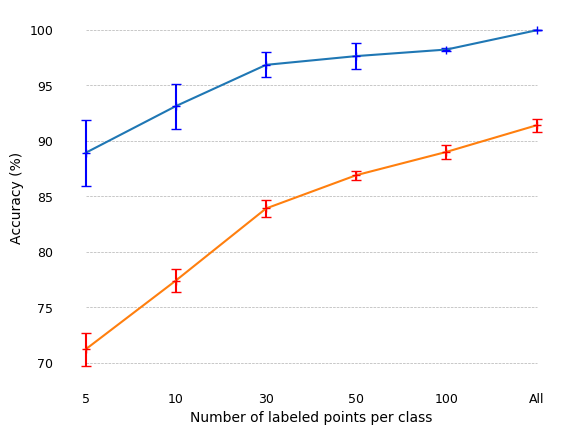

In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')

x = [0,1,2,3,4,5]
my_xticks = ['5','10','30','50','100','All']
y = [88.92,93.13,96.85,97.64,98.23,99.97]
y_fc_ladder = [71.2,77.4,83.9,86.9,89.0,91.4]

y_err_fc = [1.5,1.0,0.8,0.4,0.6,0.6]
yerr = [2.97,2.03,1.14,1.16,0.154,0.02]

ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt='b+', capsize=3.5)
ax.errorbar(x,y_fc_ladder,yerr=y_err_fc,fmt='r+',capsize=3.5)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

#Change font to Arial
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Number of labeled points per class")


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on",labelsize=9.0)

yaxis = [s for s in range(70,105,5)]
for yy in yaxis:
  plt.plot(range(0, 6), [yy] * len(range(0, 6)), "--", lw=0.5, color="black", alpha=0.3)

  
#plt.xlabel('Number of labeled points per class')
#plt.ylabel('Accuracy (%)')

plt.xticks(x, my_xticks)
plt.plot(x,y)
plt.plot(x,y_fc_ladder)

#Save the figure, assuming drive is already mounted
directory = "/content/gdrive/My Drive/colab/Ladder-CNN/Figures"
plt.savefig(directory+"/fc_vs_conv_ladder_net.jpg",quality=90)

plt.show()

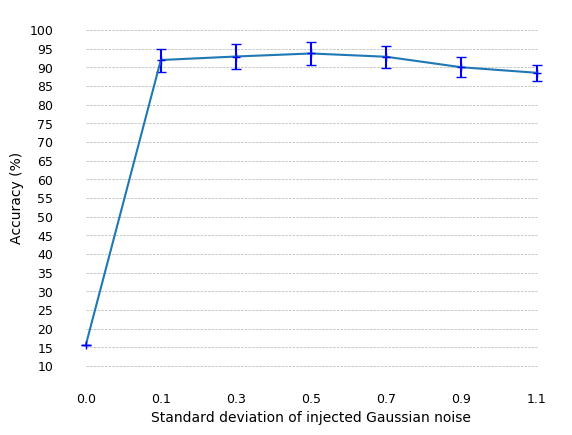

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')

x = [0,1,2,3,4,5,6]
my_xticks = ['0.0','0.1','0.3','0.5','0.7','0.9','1.1']
my_yticks = np.arange(10,105,5)
y = [15.504,91.94,92.88,93.69,92.81,90.0,88.52]

yerr = [0.0,3.08,3.34,2.99,2.89,2.73,2.19]

ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt='b+', capsize=3.5)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

#Change font to Arial
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Standard deviation of injected Gaussian noise")


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on",labelsize=9.0)

yaxis = [s for s in range(10,105,5)]
for yy in yaxis:
  plt.plot(range(0, 7), [yy] * len(range(0, 7)), "--", lw=0.5, color="black", alpha=0.3)

  
#plt.xlabel('Number of labeled points per class')
#plt.ylabel('Accuracy (%)')

plt.xticks(x, my_xticks)
plt.yticks(my_yticks)
plt.plot(x,y)

#Save the figure, assuming drive is already mounted
directory = "/content/gdrive/My Drive/colab/Ladder-CNN/Figures"
plt.savefig(directory+"/noise_stds.jpg",quality=90)

plt.show()

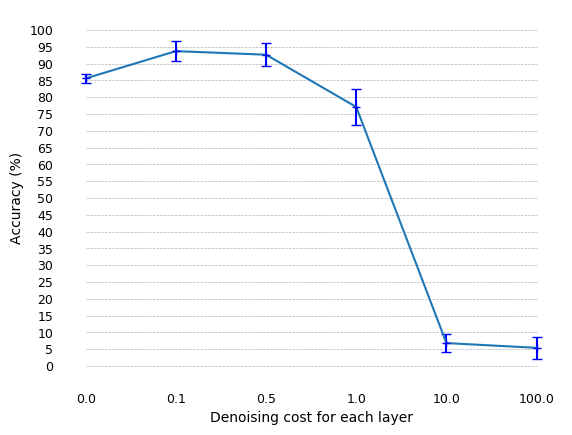

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')

x = [0,1,2,3,4,5]
my_xticks = ['0.0','0.1','0.5','1.0','10.0','100.0']
my_yticks = np.arange(0,105,5)
y = [85.57,93.69,92.62,77.07,6.80,5.38]

yerr = [1.44,2.99,3.38,5.23,2.66,3.32]

ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt='b+', capsize=3.5)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

#Change font to Arial
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Denoising cost for each layer")


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on",labelsize=9.0)

yaxis = [s for s in range(0,105,5)]
for yy in yaxis:
  plt.plot(range(0, 6), [yy] * len(range(0, 6)), "--", lw=0.5, color="black", alpha=0.3)

  
#plt.xlabel('Number of labeled points per class')
#plt.ylabel('Accuracy (%)')

plt.xticks(x, my_xticks)
plt.yticks(my_yticks)
plt.plot(x,y)

#Save the figure, assuming drive is already mounted
directory = "/content/gdrive/My Drive/colab/Ladder-CNN/Figures"
plt.savefig(directory+"/noise_costs.jpg",quality=90)

plt.show()

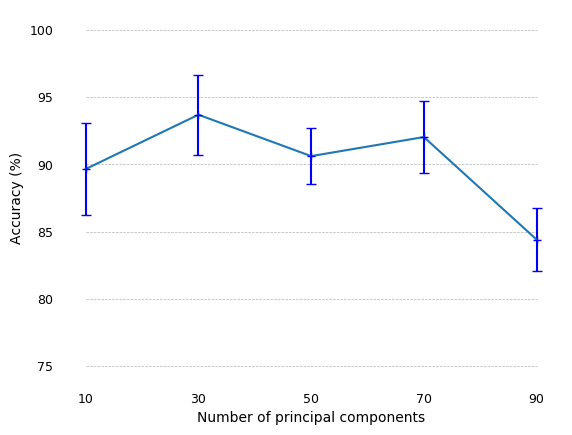

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')

x = [0,1,2,3,4]
my_xticks = ['10','30','50','70','90']
my_yticks = np.arange(75,105,5)
y = [89.65,93.69,90.61,92.03,84.40]

yerr = [3.44,2.99,2.10,2.69,2.32]

ax = plt.gca()
ax.errorbar(x, y, yerr=yerr, fmt='b+', capsize=3.5)

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False) 

ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()

#Change font to Arial
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Number of principal components")


plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on",labelsize=9.0)

yaxis = [s for s in range(75,105,5)]
for yy in yaxis:
  plt.plot(range(0, 5), [yy] * len(range(0, 5)), "--", lw=0.5, color="black", alpha=0.3)

  
#plt.xlabel('Number of labeled points per class')
#plt.ylabel('Accuracy (%)')

plt.xticks(x, my_xticks)
plt.yticks(my_yticks)
plt.plot(x,y)

#Save the figure, assuming drive is already mounted
directory = "/content/gdrive/My Drive/colab/Ladder-CNN/Figures"
plt.savefig(directory+"/pcs.jpg",quality=90)

plt.show()